# Compare real CELEX (and others) to artificial lexicons

Using the code here (https://github.com/SbllDtrch/NullLexicons) to generate artificial lexicons based on real phonotactic properties of a language. We can then compare distributional properties of the real lexicon to these artificial lexicons.

In [4]:
import src.utils as utils
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm

from tqdm import tqdm

from nlp_utilities.compling import CorpusUtilities


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## English

First we investigate the English lexicon. We compare lemmas from CELEX to a number of artificially-generated lexicons, matched for the same distribution of syllable lengths.

### Real lexicon

In [8]:
df_celex_og = pd.read_csv("data/processed/english/english_all_reals.csv")
print(len(df_celex_og))

52438


In [9]:
df_celex_processed = pd.read_csv("data/processed/english/english_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,a,4.36,1,1,ART,1,1,1,False,6,-4.543025,4.543025
1,1,4,AA,0.48,1,11,N,2,2,2,False,1,-4.726224,4.726224
2,2,6,aback,0.48,2,@b{k,ADV,2,4,2,False,0,-4.818142,4.818142
3,3,7,abacus,0.00,0,{b@k@s,N,3,6,3,False,0,-5.343813,5.343813
4,4,8,abaft,0.00,1,@b#ft,ADV,2,5,2,False,1,-5.092447,5.092447


In [10]:
df_celex_og.head(5)

,Unnamed: 0,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,num_phones,num_sylls_est,log_prob,surprisal
0,0,a,4.36,1,1,ART,1,1,1,-4.543025,4.543025
1,1,a,4.37,1,1,N,1,1,1,-4.543025,4.543025
2,2,a,2.67,0,1,NaN,1,1,1,-4.543025,4.543025
3,3,A,4.37,0,1,NaN,1,1,1,-4.543025,4.543025
4,4,AA,0.48,1,11,N,2,2,2,-4.726224,4.726224


In [11]:
REAL_HOMOPHONE_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_HOMOPHONE_PERCENTAGE

0.1564360383969009

In [12]:
df_celex_processed['num_homophones'].mean()

0.19312387842880338

### Compare to null lexicon

In [13]:
# NUM_ARTIFICIAL = 10
NUM_ARTIFICIAL = 10

In [14]:
df_english_with_sims = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls.csv")


In [15]:
df_english_with_sims['lexicon'] = df_english_with_sims['lexicon'].apply(lambda x: str(x))

In [16]:
df_english_with_sims.head(5)

,Unnamed: 0,lexicon,num_phones,num_sylls_est,prob,surprisal,word
0,0,0,6,2,-6.862922,6.862922,lItm6T
1,1,0,8,3,-5.093740,5.093740,k{pIt@nt
2,2,0,7,3,-4.923106,4.923106,{ntIdlI
3,3,0,9,3,-6.755240,6.755240,Vnwildw3k
4,4,0,6,2,-6.177147,6.177147,kr$lIk


### Topographic map?

In [12]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
# https://medium.com/@sebastiannorena/3d-plotting-in-python-b0dc1c2e5e38

In [13]:
import numpy as np

In [14]:
from Levenshtein import distance
from sklearn.decomposition import PCA

In [15]:
def produce_phonological_space(words, n=2):
    """Produce dimensionality-reduced map of phonological space."""
    Target = words

    List1 = Target
    List2 = Target

    X = np.zeros((len(List1),len(List2)),dtype=np.int)

    for i in tqdm(range(0,len(List1))):
        for j in range(0,len(List2)):
            X[i,j] = distance(List1[i],List2[j])
            
    pca = PCA(n_components=2)
    
    X_transformed = pca.fit_transform(X)  
    return X, X_transformed

In [25]:
# df_mono = df_celex_processed[df_celex_processed['SylCnt']<=1].head(5000)

df_mono = df_celex_processed.sample(3000)

In [26]:
X, X_transformed = produce_phonological_space(df_mono['PhonDISC'].values)

100%|██████████| 3000/3000 [00:07<00:00, 406.22it/s]


In [27]:
pairs = []
for row in tqdm(X):
    num_pairs = len([j for j in row if j ==1])
    pairs.append(num_pairs)

100%|██████████| 3000/3000 [00:03<00:00, 897.43it/s]


In [28]:
df_mds = pd.DataFrame(X_transformed, columns=['d1', 'd2'])

In [29]:
df_mds['PhonDISC'] = list(df_mono['PhonDISC'])

In [30]:
df_both = pd.merge(df_mds, df_mono, on="PhonDISC")
df_both['num_pairs'] = pairs

In [31]:
from mpl_toolkits import mplot3d

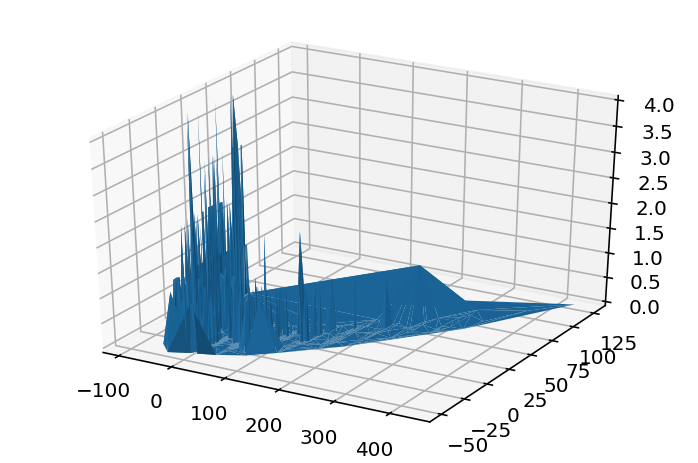

In [32]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(df_both['d1'], df_both['d2'], df_both['num_homophones'],
               linewidth=0.2, antialiased=True)

In [33]:
result = sm.poisson(formula="num_homophones ~ num_pairs + surprisal + num_sylls_est", 
                    data=df_both).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.470758
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                 3000
Model:                        Poisson   Df Residuals:                     2996
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 May 2019   Pseudo R-squ.:                  0.1513
Time:                        15:26:06   Log-Likelihood:                -1412.3
converged:                       True   LL-Null:                       -1664.0
                                        LLR p-value:                8.389e-109
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.0038      0.453      4.424      0.000       1.116       2.891
num_pairs         0.2390      0.035      6.801      0.000       0.170       0.308
surprisal        -0.4519      0.101     -4.481      0.000      -0.650      -0.254
num_sylls_est    -0.6240      0.066     -9.502      0.000      -0.753      -0.495
=================================================================================
"""

In [35]:
df_english = df_english_with_sims[df_english_with_sims['lexicon']=="2"]
df_english_processed = utils.preprocess_for_analysis(df_english,
                                                      phon_column="word", word_column="word")
df_mono2 = df_english_processed.sample(3000)

In [36]:
X, X_transformed = produce_phonological_space(df_mono2['word'].values)

100%|██████████| 3000/3000 [00:07<00:00, 408.29it/s]


In [37]:
pairs = []
for row in tqdm(X):
    num_pairs = len([j for j in row if j ==1])
    pairs.append(num_pairs)

100%|██████████| 3000/3000 [00:03<00:00, 904.65it/s]


In [38]:
df_mds = pd.DataFrame(X_transformed, columns=['d1', 'd2'])

In [39]:
df_mds['word'] = list(df_mono2['word'])

In [40]:
df_both = pd.merge(df_mds, df_mono2, on="word")
df_both['num_pairs'] = pairs

In [41]:
result = sm.poisson(formula="num_homophones ~ num_pairs + surprisal + num_sylls_est", 
                    data=df_both).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.297594
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                 3000
Model:                        Poisson   Df Residuals:                     2996
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 May 2019   Pseudo R-squ.:                  0.5263
Time:                        15:26:30   Log-Likelihood:                -892.78
converged:                       True   LL-Null:                       -1884.7
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.1316      0.403     35.078      0.000      13.342      14.921
num_pairs        -0.0019      0.080     -0.023      0.981      -0.158       0.154
surprisal        -2.5858      0.074    -34.829      0.000      -2.731      -2.440
num_sylls_est    -0.7640      0.064    -11.945      0.000      -0.889      -0.639
=================================================================================
"""

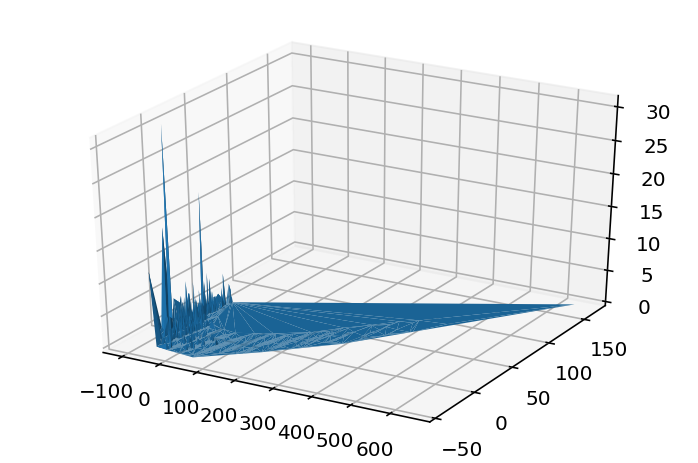

In [42]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(df_both['d1'], df_both['d2'], df_both['num_homophones'])

#### Phonotactics

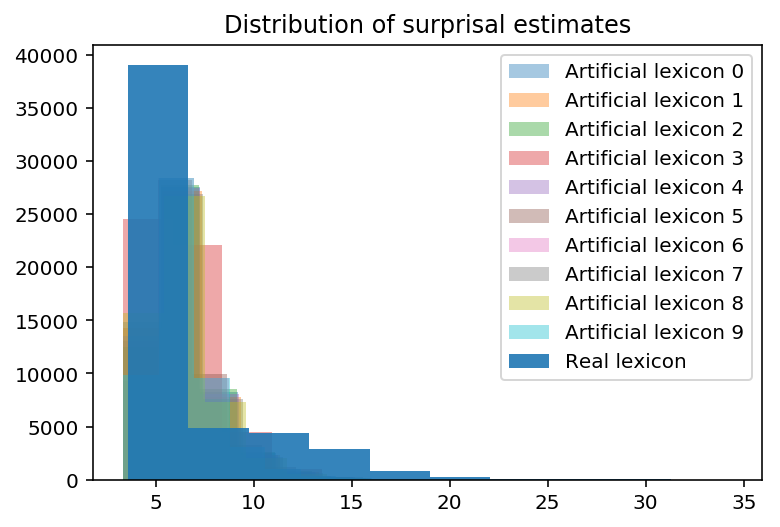

In [12]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

In [53]:
import seaborn as sns

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of surprisal estimates')

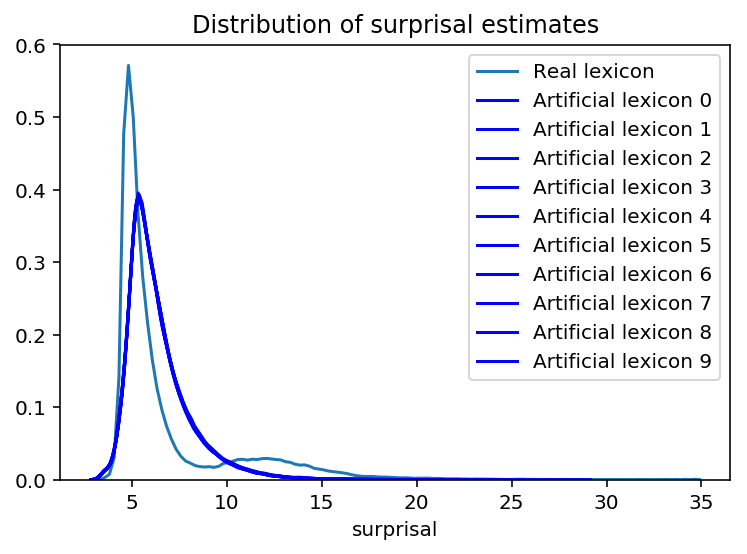

In [13]:
sns.distplot(df_celex_og['surprisal'], hist=False, label = "Real lexicon")

for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    sns.distplot(df_tmp['surprisal'], color = "blue", hist=False, label = "Artificial lexicon {x}".format(x=i))

plt.title("Distribution of surprisal estimates")


#### Lengths

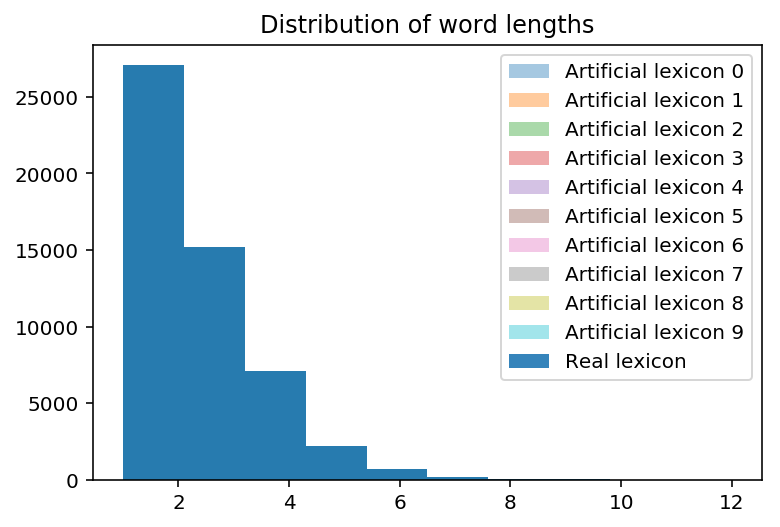

In [17]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

# plt.hist(df_english_with_sims[df_english_with_sims['lexicon']=="real"]['length'], 
#          alpha = .6, label = "Real lexicon".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
          alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of word lengths")
plt.legend()

#### Homophones

##### Number of homophones

In [18]:
processed_artificials = []
homophone_percentages = []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_english_with_sims[df_english_with_sims['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))
    
    processed_artificials.append(df_tmp_processed)


  0%|          | 0/10 [00:00<?, ?it/s]

52438


 10%|█         | 1/10 [00:00<00:07,  1.22it/s]

52438


 20%|██        | 2/10 [00:01<00:06,  1.23it/s]

52438


 30%|███       | 3/10 [00:02<00:05,  1.23it/s]

52438


 40%|████      | 4/10 [00:03<00:05,  1.16it/s]

52438


 50%|█████     | 5/10 [00:04<00:04,  1.09it/s]

52438


 60%|██████    | 6/10 [00:05<00:03,  1.02it/s]

52438


 70%|███████   | 7/10 [00:06<00:02,  1.05it/s]

52438


 80%|████████  | 8/10 [00:07<00:01,  1.08it/s]

52438


 90%|█████████ | 9/10 [00:08<00:00,  1.03it/s]

52438


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


No handles with labels found to put in legend.


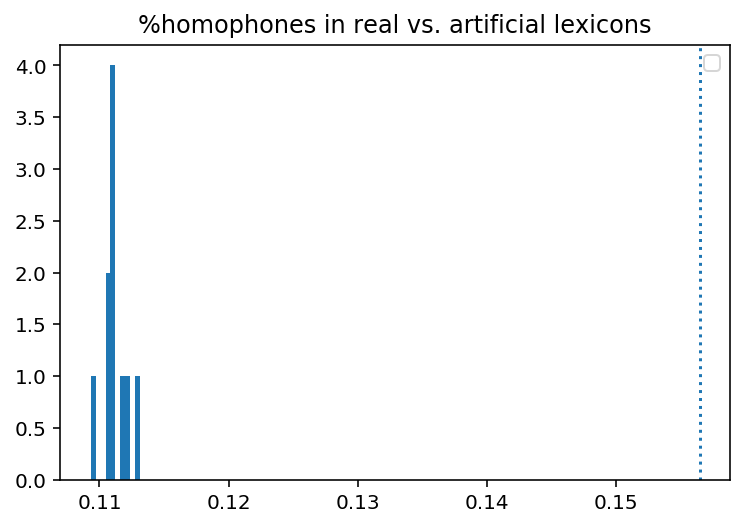

In [146]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_HOMOPHONE_PERCENTAGE, linestyle="dotted")


##### Distribution of homophones

In [150]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='num_sylls_est', 
                                          homophone_column='num_homophones')

##### By syllables

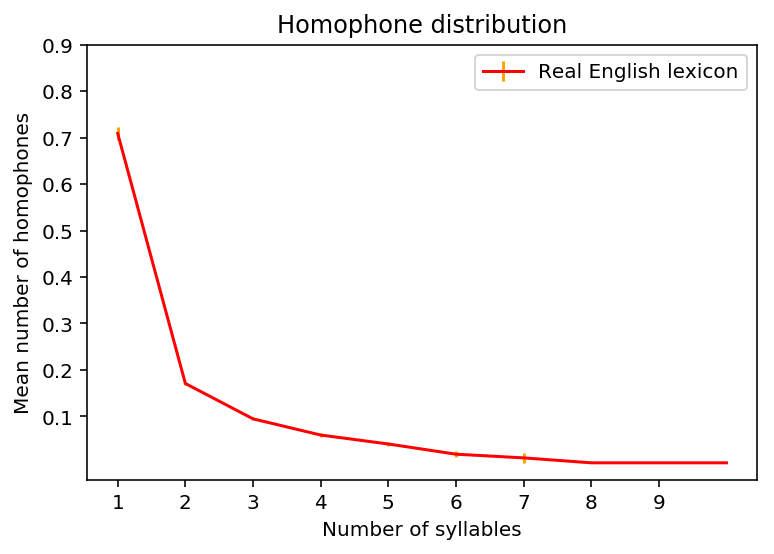

In [156]:
### First plot real
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")
plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9])
plt.legend(loc='upper right')

In [157]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


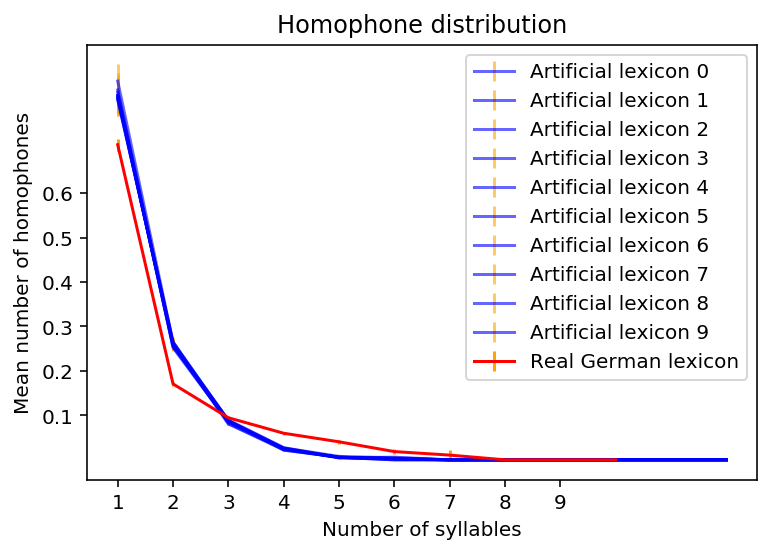

In [158]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

#### Statistics 

Interestingly, whether the **real slope** falls to the left or right of the simulated distribution appears to depend on whether **surprisal** is included as a covariate. If it is, then the **real slope** surpasses the **simulated lexicons**––e.g. above "chance". But if it's not, then it's weaker than "chance".

In [159]:
slope_coefs_english = []
surprisal_coefs_english = []
for df_tmp_processed in processed_artificials:    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit()
    slope_coefs_english.append(result.params['num_sylls_est'])
    surprisal_coefs_english.append(result.params['surprisal'])

Optimization terminated successfully.
         Current function value: 0.311292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.313094
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.306873
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.311377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.312270
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.309452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310415
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.309515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310480
  

In [160]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit()
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

Optimization terminated successfully.
         Current function value: 0.470802
         Iterations 6


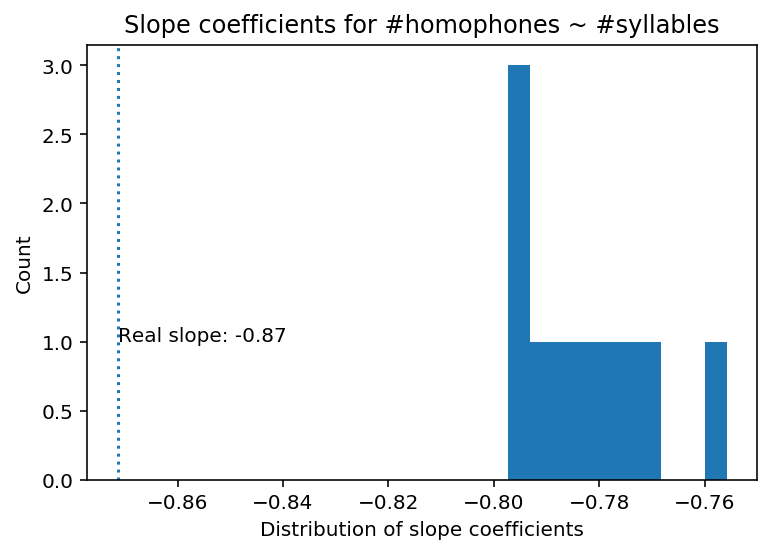

In [162]:
plt.hist(slope_coefs_english)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

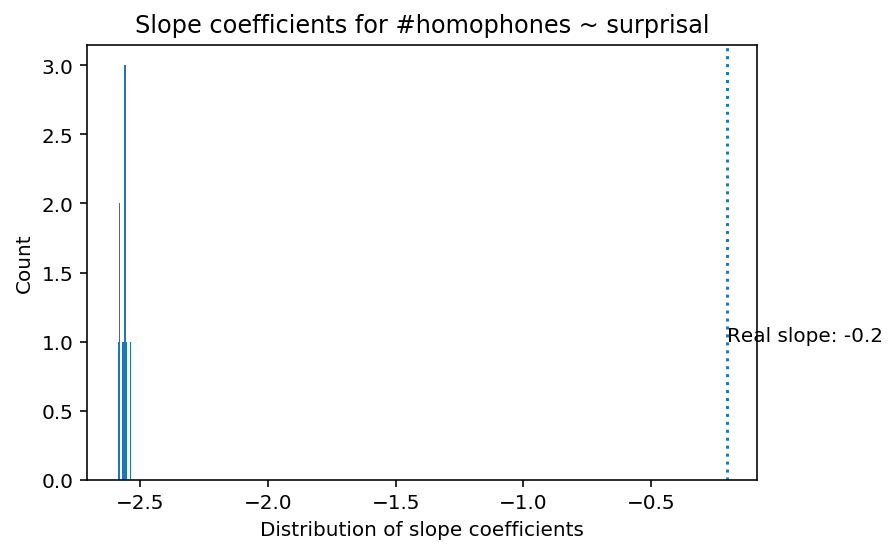

In [164]:
plt.hist(surprisal_coefs_english)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## German

### Real lexicon

In [165]:
df_celex_og = pd.read_csv("data/processed/german/german_all_reals.csv")

In [166]:
len(df_celex_og)

51719

In [167]:
df_celex_processed = pd.read_csv("data/processed/german/german_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,Word,CompCnt,PhonDISC,SylCnt,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,A,1,a,1,1,1,False,1,-4.700550,4.700550
1,1,1,Ae,1,),1,1,1,False,0,-4.708451,4.708451
2,2,2,aalen,1,al@n,2,4,2,False,0,-4.999407,4.999407
3,3,3,Aal,1,al,1,2,1,False,0,-4.736787,4.736787
4,4,4,aalglatt,2,algl&t,2,6,2,False,0,-6.063007,6.063007


In [168]:
len(df_celex_processed)

50474

In [171]:
REAL_GERMAN_PERCENTAGE = round(len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed),
                               2)
REAL_GERMAN_PERCENTAGE

0.02

In [172]:
df_celex_processed['num_homophones'].mean()

0.024646352577564687

### Compare to null lexicon

In [173]:
# NUM_ARTIFICIAL = 10
NUM_ARTIFICIAL = 10

In [174]:
df_german_artificials = pd.read_csv("data/processed/german/german_artificial_10_matched_on_sylls.csv")

In [175]:
df_german_artificials['lexicon'] = df_german_artificials['lexicon'].apply(lambda x: str(x))

In [176]:
df_german_artificials.head(5)

,Unnamed: 0,lexicon,num_phones,num_sylls_est,prob,surprisal,word
0,0,0,7,2,-6.939665,6.939665,k<lBf@n
1,1,0,7,3,-6.100064,6.100064,kOt@lIx
2,2,0,11,4,-8.701623,8.701623,b@S&t@nrExt
3,3,0,4,2,-4.558483,4.558483,demi
4,4,0,8,3,-5.402361,5.402361,WnStX@rn


In [177]:
len(df_german_artificials)

517190

#### Phonotactics

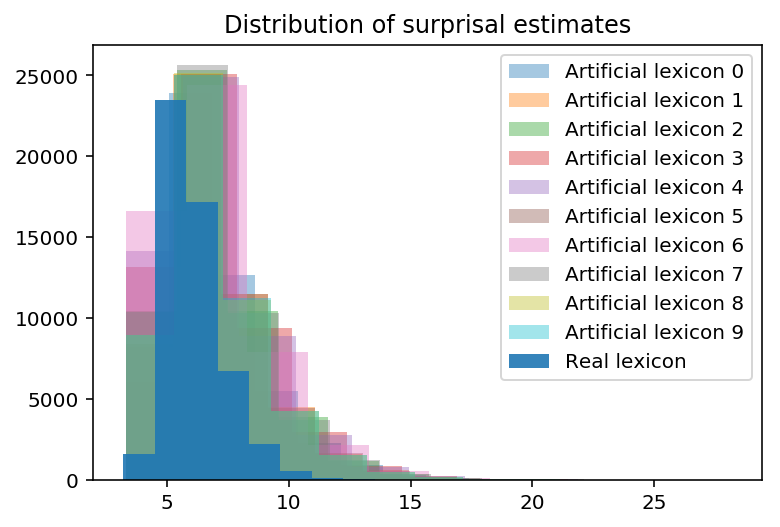

In [178]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

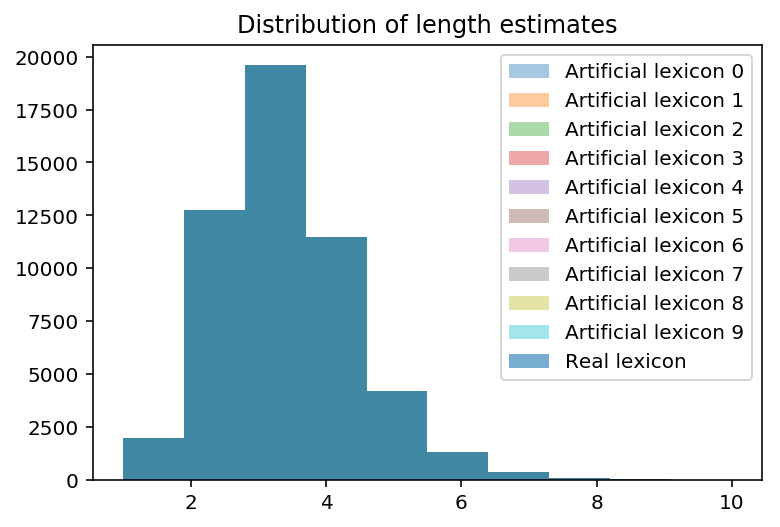

In [179]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    # df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
    #                                                  phon_column="word", word_column="word")
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .6, label = "Real lexicon".format(x=i))
plt.title("Distribution of length estimates")
plt.legend()

#### Homophones

##### Number of homophones

In [182]:
processed_artificials = []

In [183]:
homophone_percentages = []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_german_artificials[df_german_artificials['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))
    
    processed_artificials.append(df_tmp_processed)


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


No handles with labels found to put in legend.


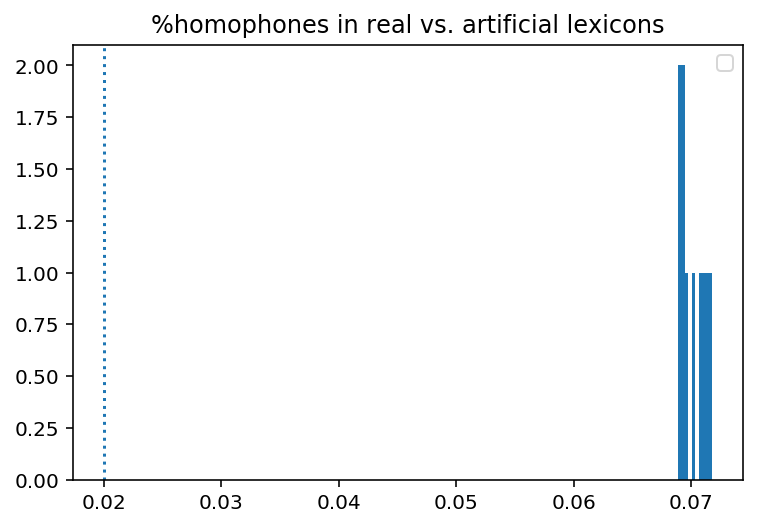

In [184]:
plt.hist(homophone_percentages)
plt.title("%homophones in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_GERMAN_PERCENTAGE, linestyle="dotted")


##### Distribution of homophones

In [185]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

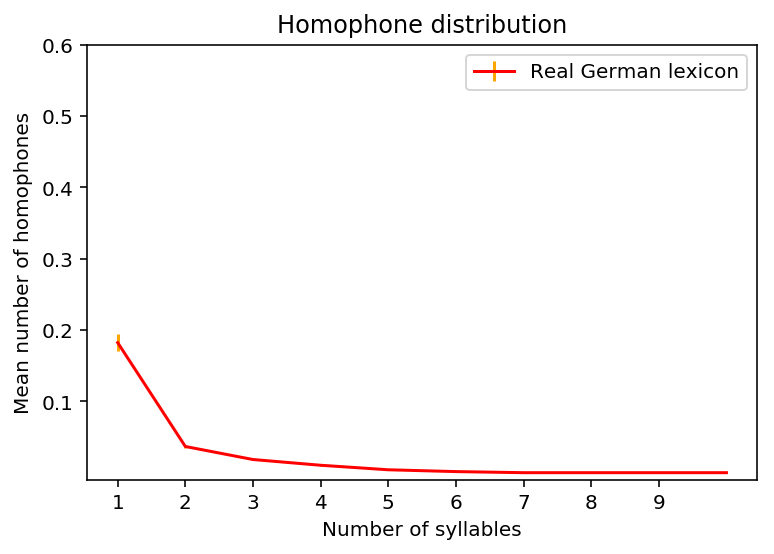

In [186]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

In [187]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

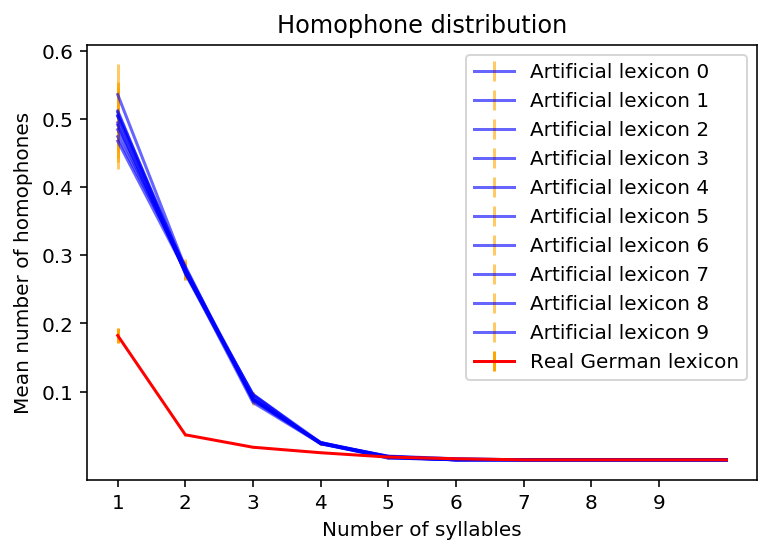

In [188]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real German lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.legend(loc='upper right')

### Statistics

As with English, the coefficient on **number of syllables** depends on whether **surprisal** is included. If it is, the real lexicon has a larger magnitude coefficient than the simulated ones; if not, the other way around.

In [189]:
slope_coefs = []
surprisal_coefs_german = []
for df_tmp_processed in processed_artificials:    
    # df_tmp = df_tmp[df_tmp['in_celex']==False]
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit()
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_german.append(result.params['surprisal'])

Optimization terminated successfully.
         Current function value: 0.201630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206680
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208320
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204397
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209877
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206434
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.203130
  

In [192]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit()
real_slope = round(result_real.params['num_sylls_est'], 2)
surprisal_slope = round(result_real.params['surprisal'], 2)

Optimization terminated successfully.
         Current function value: 0.103383
         Iterations 7


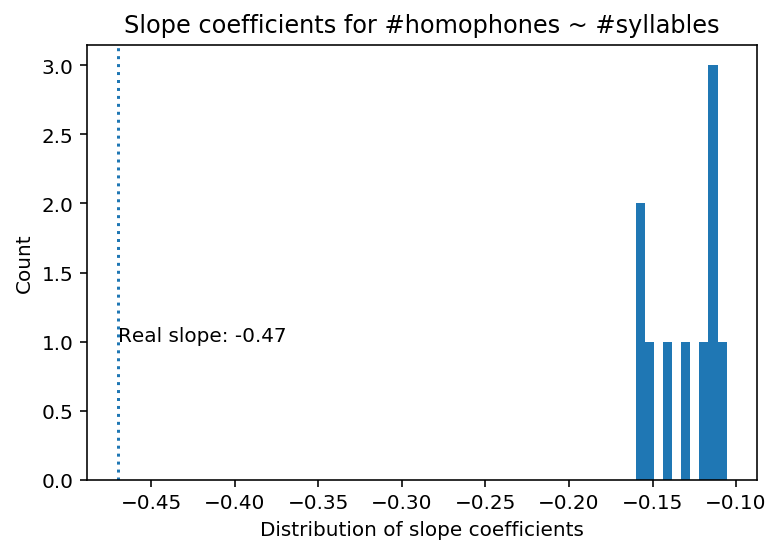

In [193]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=real_slope),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

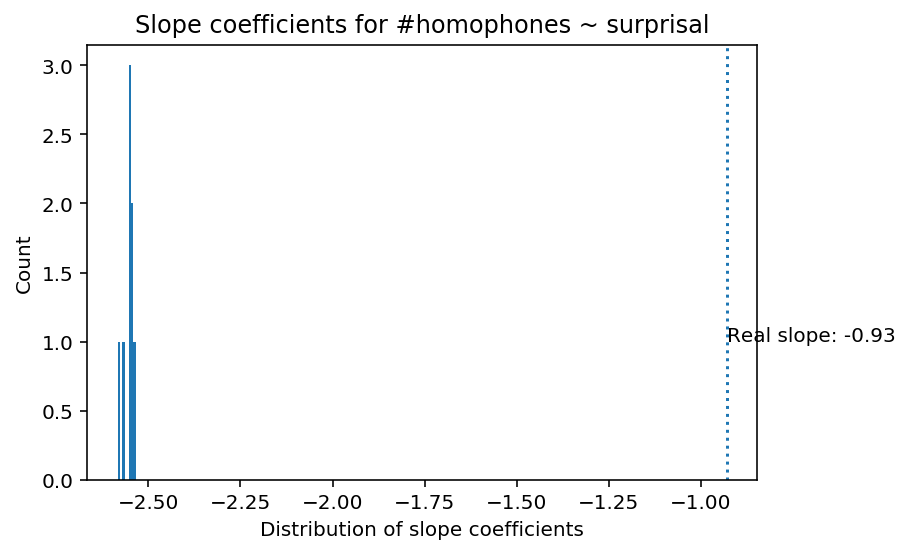

In [194]:
plt.hist(surprisal_coefs_german)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()

## Dutch

### Real lexicon

In [195]:
df_celex_og = pd.read_csv("data/processed/dutch/dutch_all_reals.csv")

In [196]:
len(df_celex_og)

67910

In [197]:
df_celex_processed = pd.read_csv("data/processed/dutch/dutch_lemmas_processed.csv")
df_celex_processed.head(5)

,Unnamed: 0,index,IdNum,Word,Inl,PhonStrsDISC,PhonCVBr,PhonSylBCLX,PhonStrsStDISC,PhonStCVBr,PhonSylStBCLX,PhonolCLX,PhonolCPA,PhonDISC,num_phones,num_sylls_est,remove,num_homophones,log_prob,surprisal
0,0,0,1,a,1986,'a,[VV],[a:],'a,[VV],[a:],a:,a:,a,1,1,False,2,-4.811078,4.811078
1,1,5,6,aagt,0,'axt,[VVCC],[a:xt],'axt,[VVCC],[a:xt],a:xt,a:xt,axt,3,1,False,0,-4.975899,4.975899
2,2,6,7,aagtappel,0,'axt-A-p@l,[VVCC][V[C]VC],[a:xt][A[p]@l],'axt-A-p@l,[VVCC][V[C]VC],[a:xt][A[p]@l],a:xt#A-p@l,a:xt#A.p@l,axtAp@l,7,3,False,0,-7.062558,7.062558
3,3,7,8,aai,27,'aj,[VVC],[a:j],'aj,[VVC],[a:j],a:j,a:j,aj,2,1,False,0,-4.867806,4.867806
4,4,8,9,aaien,446,'a-j@,[VV][CV],[a:][j@],'aj,[VVC],[a:j],a:j,a:j,aj@,3,2,False,0,-5.018821,5.018821


In [198]:
len(df_celex_processed)

65351

In [199]:
REAL_DUTCH_PERCENTAGE = len(df_celex_processed[df_celex_processed['num_homophones']>0]) / len(df_celex_processed)
REAL_DUTCH_PERCENTAGE

0.029242092699423114

### Compare to artificial lexicons

In [200]:
NUM_ARTIFICIAL = 10

In [201]:
df_dutch_artificial = pd.read_csv("data/processed/dutch/dutch_artificial_10_matched_on_sylls.csv")


In [202]:
len(df_dutch_artificial)

679100

In [203]:
df_dutch_artificial['lexicon'] = df_dutch_artificial['lexicon'].apply(lambda x: str(x))

#### Phonotactics

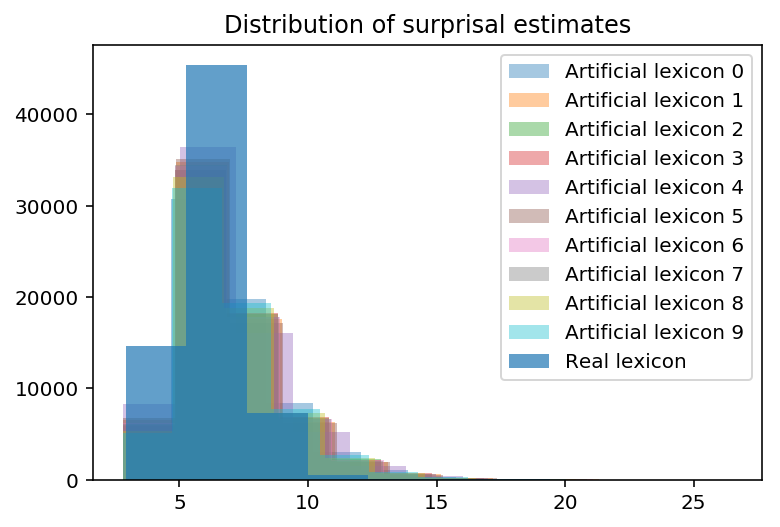

In [204]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['surprisal'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['surprisal'], 
         alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of surprisal estimates")
plt.legend()

#### Length

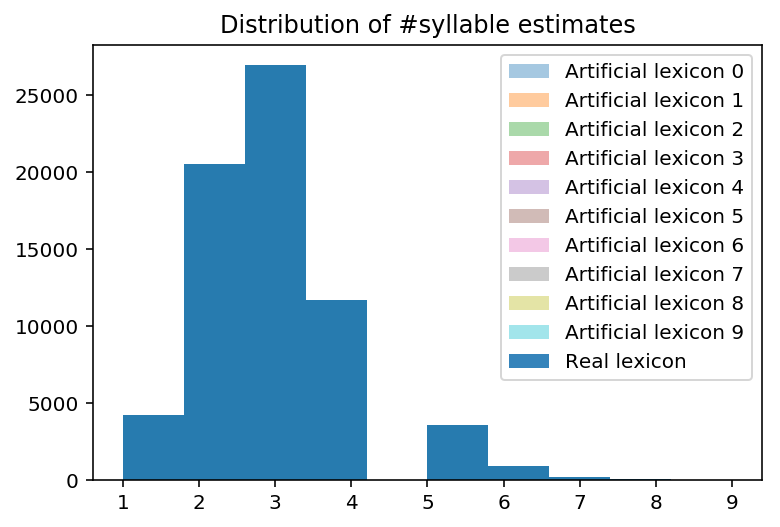

In [205]:
for i in range (NUM_ARTIFICIAL):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    plt.hist(df_tmp['num_sylls_est'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))

plt.hist(df_celex_og['num_sylls_est'], 
         alpha = .9, label = "Real lexicon".format(x=i))
plt.title("Distribution of #syllable estimates")
plt.legend()

#### Homophones

##### Number of homophones

In [206]:
processed_artificials = []

In [207]:
homophone_percentages = []
for i in tqdm(range(NUM_ARTIFICIAL)):
    
    df_tmp = df_dutch_artificial[df_dutch_artificial['lexicon']==str(i)]
    
    df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                      phon_column="word", word_column="word")
    
    homophone_percentages.append(len(df_tmp_processed[df_tmp_processed['num_homophones']>0]) / len(df_tmp_processed))
    
    processed_artificials.append(df_tmp_processed)


 20%|██        | 2/10 [00:02<00:08,  1.01s/it]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


No handles with labels found to put in legend.


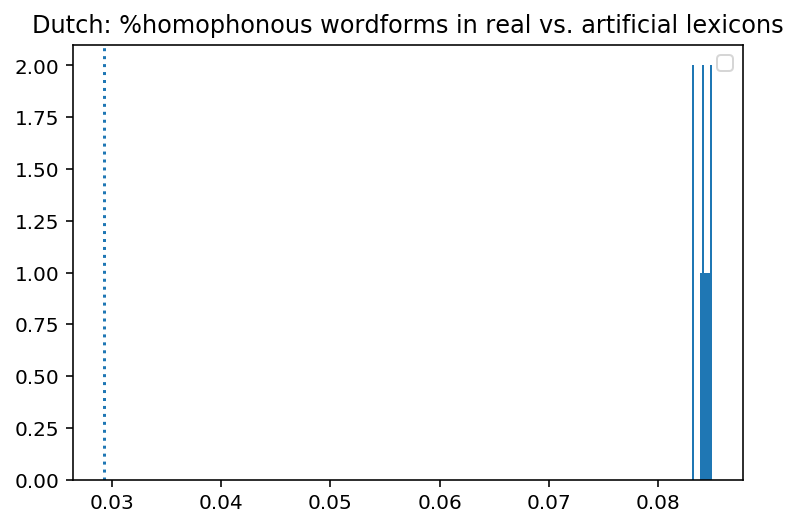

In [208]:
plt.hist(homophone_percentages)
plt.title("Dutch: %homophonous wordforms in real vs. artificial lexicons")
plt.legend()
plt.axvline(x=REAL_DUTCH_PERCENTAGE, linestyle="dotted")


##### Distribution of homophones

In [209]:
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                               syl_column='num_sylls_est', 
                                               # syl_column='SylCnt', 
                                               homophone_column='num_homophones')

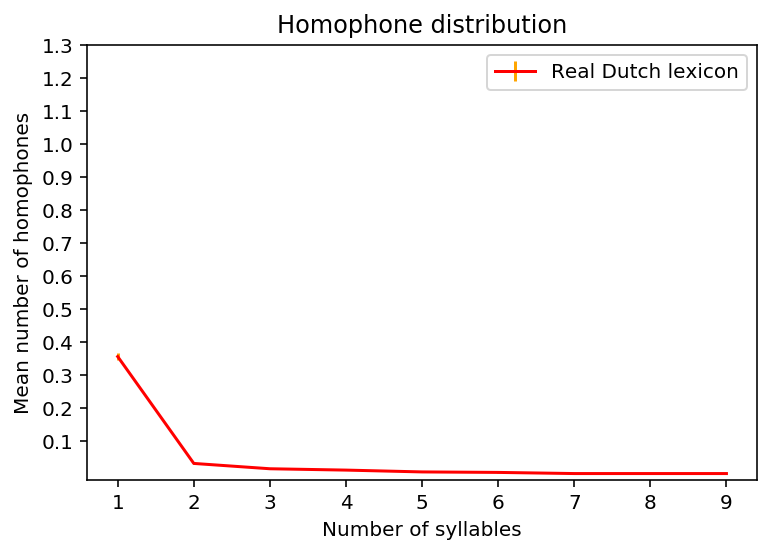

In [210]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Dutch lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3])
plt.legend(loc='upper right')

In [211]:
artificials = []
for df_tmp_processed in processed_artificials:
    
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

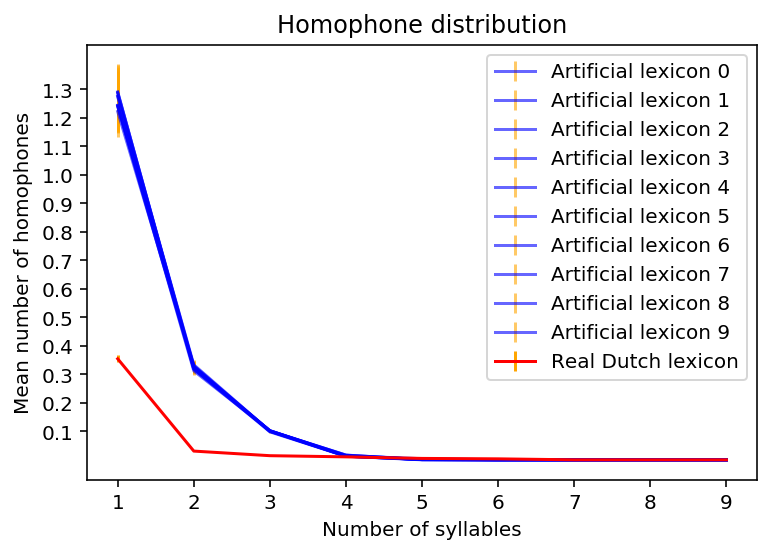

In [212]:
plt.title("Homophone distribution")
plt.xlabel("Number of syllables")
plt.ylabel("Mean number of homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real Dutch lexicon")
plt.xticks(list(range(1, 10)))
plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1, 1.2, 1.3])
plt.legend(loc='upper right')

### Statistics

In [213]:
result_real = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_celex_processed).fit()
real_slope = result_real.params['num_sylls_est']
surprisal_slope = result_real.params['surprisal']

Optimization terminated successfully.
         Current function value: 0.123772
         Iterations 7


In [214]:
slope_coefs = []
surprisal_coefs_dutch = []
for df_tmp_processed in processed_artificials:    
    result = sm.poisson(formula="num_homophones ~ num_sylls_est + surprisal", 
                    data=df_tmp_processed).fit()
    slope_coefs.append(result.params['num_sylls_est'])
    surprisal_coefs_dutch.append(result.params['surprisal'])

Optimization terminated successfully.
         Current function value: 0.247809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244179
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.246315
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.246555
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.247937
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.247044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244573
  

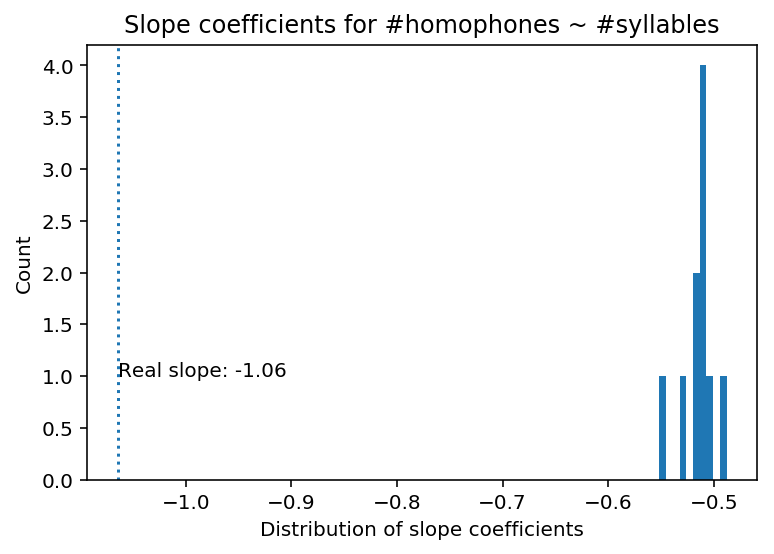

In [215]:
plt.hist(slope_coefs)
plt.axvline(x=real_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(real_slope, 2)),x=real_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
# plt.legend(loc='upper right')
plt.show()

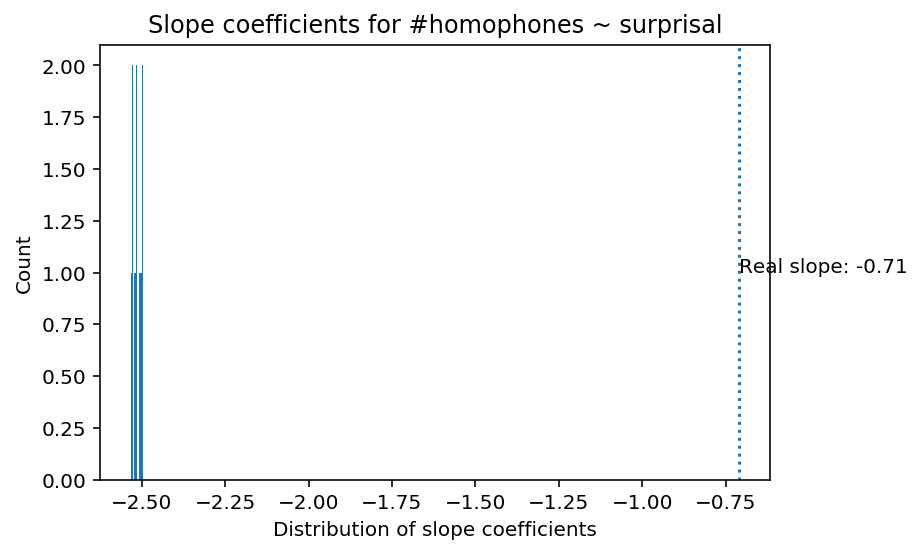

In [216]:
plt.hist(surprisal_coefs_dutch)
plt.axvline(x=surprisal_slope, linestyle="dotted")
plt.text(s="Real slope: {sl}".format(sl=round(surprisal_slope, 2)),x=surprisal_slope, y =1)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ surprisal")
# plt.legend(loc='upper right')
plt.show()